# Chapter 2: Image clustering
This chapter contains the followings:

1. Read images from the CIFAR10 dataset
1. Extract a deep feature (VGG16 fc6 activation) from each image using Keras
1. Run clustering on deep features
1. Visualize the result of image clustering

Requisites:
- numpy
- pqkmeans
- keras
- tqdm
- scipy
- matplotlib

## 1. Read images from the CIFAR10 dataset

In [1]:
import numpy
import pqkmeans
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In this chapter, we show an example of image clustering. A deep feature (VGG16 fc6 activation) is extracted from each image using Keras, then the features are clustered using PQk-means.

First, let's read images from the CIFAR10 dataset.

In [2]:
from keras.datasets import cifar10
(img_train, _), (img_test, _) = cifar10.load_data()

Using TensorFlow backend.


When you run the above cell for the first time, this would take several minutes to download the dataset to your local space (typically ~/.keras/datasets).

The CIFAR10 dataset contains small color images, where each image is uint8 RGB 32x32 array. The shape of `img_train` is (50000, 3, 32, 32), and that of `img_test` is (10000, 3, 32, 32). Let's see some of them.

The first image of img_train:



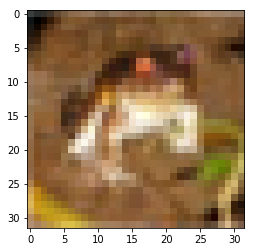

In [3]:
print("The first image of img_train:\n")
plt.imshow(img_train[0])

To train a PQ-encoder, we pick up the top 1000 images from `img_train`. The clustering will be run on the top 5000 images from `img_test`.

In [4]:
img_train = img_train[0:1000]
img_test = img_test[0:5000]
print("img_train.shape:\n{}".format(img_train.shape))
print("img_test.shape:\n{}".format(img_test.shape))

img_train.shape:
(1000, 32, 32, 3)
img_test.shape:
(5000, 32, 32, 3)


## 2. Extract a deep feature (VGG16 fc6 activation) from each image using Keras


Next, let us extract a 4096-dimensional deep feature from each image. For the feature extactor, we employ an activation from the 6th full connected layer (in Keras implementation, it is called `fc1`) of the ImageNet pre-trained VGG16 model. See the [tutorial of keras](https://keras.io/applications/) for more details. 

In [5]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.misc import imresize

base_model = VGG16(weights='imagenet')  # Read the ImageNet pre-trained VGG16 model
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)  # We use the output from the 'fc1' layer

def extract_feature(model, img):
    # This function takes a RGB image (np.array with the size (H, W, 3)) as an input, then return a 4096D feature vector.
    # Note that this can be accelerated by batch-processing.
    x = imresize(img, (224, 224))  # Resize to 224x224 since the VGG takes this size as an input
    x = numpy.float32(x)  # Convert from uint8 to float32
    x = numpy.expand_dims(x, axis=0)  # Convert the shape from (224, 224) to (1, 224, 224)
    x = preprocess_input(x)  # Subtract the average value of ImagNet.
    feature = model.predict(x)[0]  # Extract a feature, then reshape from (1, 4096) to (4096, )
    feature /= numpy.linalg.norm(feature)  # Normalize the feature.
    return feature

For the first time, this also takes several minutes to download the ImageNet pre-trained weights.

Let us extract features from images as follows. This takes several minutes using a usual GPU such as GTX1080.

In [6]:
features_train = numpy.array([extract_feature(model, img) for img in tqdm.tqdm(img_train)])
features_test = numpy.array([extract_feature(model, img) for img in tqdm.tqdm(img_test)])
print("features_train.shape:\n{}".format(features_train.shape))
print("features_test.shape:\n{}".format(features_test.shape))

100%|██████████| 5000/5000 [01:05<00:00, 76.91it/s]

features_train.shape:
(1000, 4096)
features_test.shape:
(5000, 4096)


Now we have a set of 4096D features for both the train-dataset and the test-dataset. Note that `features_train[0]` is an image descriptor for `img_train[0]`

## 3. Run clustering on deep features

Let us train a PQ-encoder using the training dataset, and compress the deep features into PQ-codes

In [7]:
# Train an encoder
encoder = pqkmeans.encoder.PQEncoder(num_subdim=4, Ks=256)
encoder.fit(features_train)

# Encode the deep features to PQ-codes
pqcodes_test = encoder.transform(features_test)
print("pqcodes_test.shape:\n{}".format(pqcodes_test.shape))

# Run clustering
K = 10
print("Runtime of clustering:")
%time clustered = pqkmeans.clustering.PQKMeans(encoder=encoder, k=K).fit_predict(pqcodes_test)

pqcodes_test.shape:
(5000, 4)
Runtime of clustering:
CPU times: user 1.36 s, sys: 8 ms, total: 1.37 s
Wall time: 283 ms


## 4. Visualize the result of image clustering

Now we can visualize image clusters. As can be seen, each cluster has similar images such as "horses", "cars", etc.

Cluster id: k=0


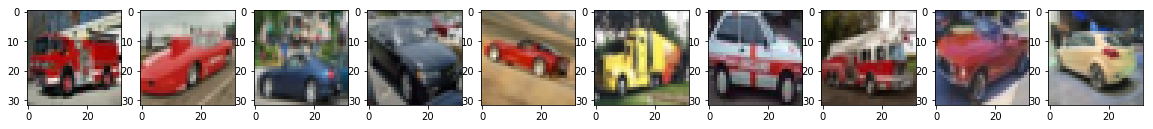

Cluster id: k=1


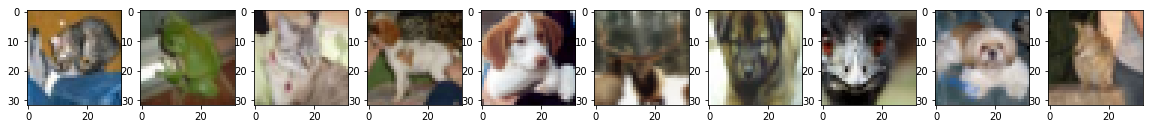

Cluster id: k=2


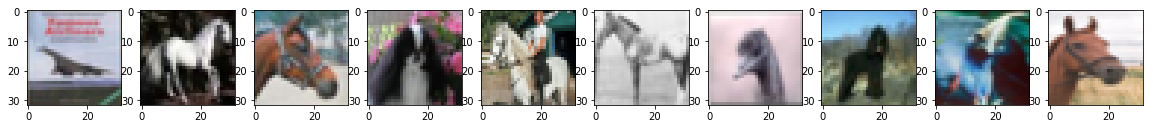

Cluster id: k=3


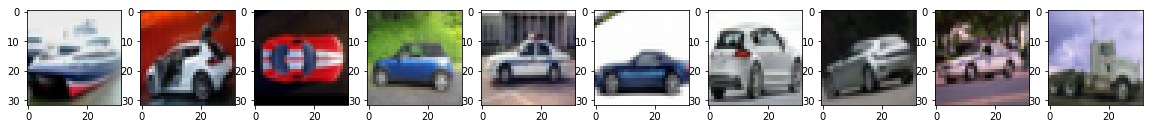

Cluster id: k=4


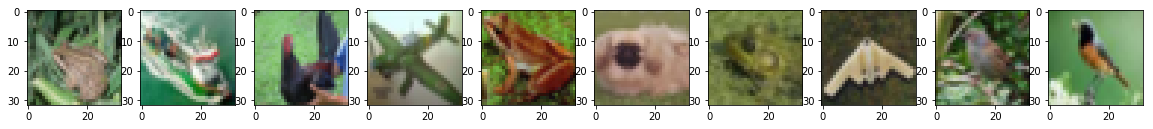

Cluster id: k=5


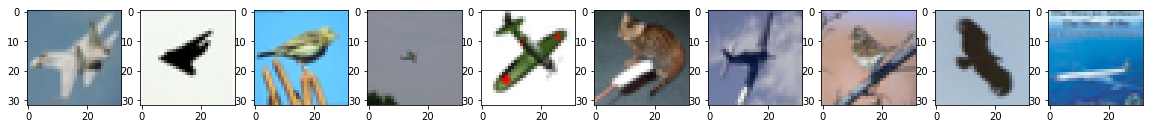

Cluster id: k=6


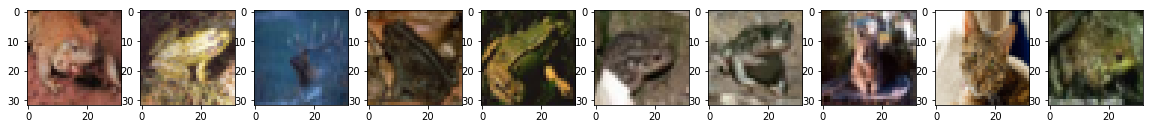

Cluster id: k=7


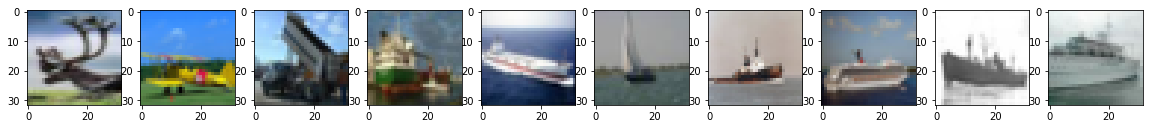

Cluster id: k=8


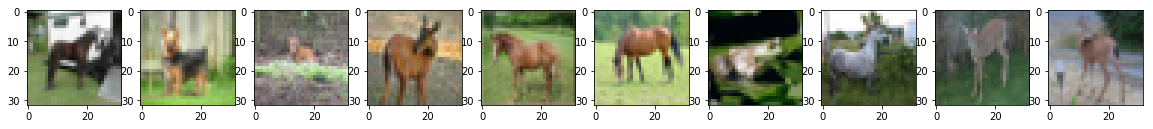

Cluster id: k=9


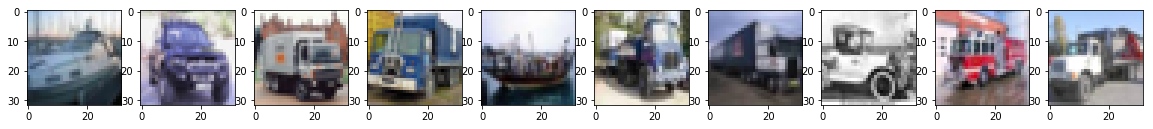

In [8]:
for k in range(K):
    print("Cluster id: k={}".format(k))
    img_ids = [img_id for img_id, cluster_id in enumerate(clustered) if cluster_id == k]

    cols = 10
    img_ids = img_ids[0:cols] if cols < len(img_ids) else img_ids # Let's see the top 10 results
    
    # Visualize images assigned to this cluster
    imgs = img_test[img_ids]
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
    plt.show()
